# Object Detection with AWS: A Demo with Boots and Cats

This series of notebooks demonstrates tackling a sample computer vision problem on AWS - building a two-class object detector for [boots and cats](https://www.youtube.com/watch?v=Nni0rTLg5B8).

**This notebook** walks through using the [SageMaker Ground Truth](https://aws.amazon.com/sagemaker/groundtruth/) tool to annotate training and validation data sets.

**Follow-on** notebooks show how to train a range of models on the task including:

* [Amazon Rekognition](https://aws.amazon.com/rekognition/)'s new [custom labels](https://aws.amazon.com/rekognition/custom-labels-features/) functionality, announced at Re:Invent 2019
* SageMaker's [built-in object detection algorithm](https://docs.aws.amazon.com/sagemaker/latest/dg/object-detection.html)

# Boots 'n' Cats 1: Introduction and Data Preparation

## Acknowledgements

We use the [**Open Images Dataset v4**](https://storage.googleapis.com/openimages/web/download_v4.html) as a convenient source of pre-curated images. The Open Images Dataset V4 is created by Google Inc. We have not modified the images or the accompanying annotations. You can obtain the images and the annotations [here](https://storage.googleapis.com/openimages/web/download_v4.html). The annotations are licensed by Google Inc. under CC BY 4.0 license. The images are listed as having a CC BY 2.0 license. The following paper describes Open Images V4 in depth: from the data collection and annotation to detailed statistics about the data and evaluation of models trained on it.

A. Kuznetsova, H. Rom, N. Alldrin, J. Uijlings, I. Krasin, J. Pont-Tuset, S. Kamali, S. Popov, M. Malloci, T. Duerig, and V. Ferrari. The Open Images Dataset V4: Unified image classification, object detection, and visual relationship detection at scale. arXiv:1811.00982, 2018. ([link to PDF](https://arxiv.org/abs/1811.00982))

## Pre-requisites

This notebook is designed to be run in Amazon SageMaker. To run it (and understand what's going on), you'll need:

* Basic familiarity with Python, [AWS S3](https://docs.aws.amazon.com/s3/index.html), [Amazon Sagemaker](https://aws.amazon.com/sagemaker/), and the [AWS Command Line Interface (CLI)](https://aws.amazon.com/cli/).
* To run in **a region where Rekognition custom labelling is available** (Only N. Virginia at launch), if you plan to explore this feature.
* To create an **S3 bucket** in the same region, and ensure the SageMaker notebook's role has access to this bucket.
* Sufficient [SageMaker quota limits](https://docs.aws.amazon.com/general/latest/gr/aws_service_limits.html#limits_sagemaker) set on your account to run GPU-accelerated training jobs.

## Cost and runtime

Depending on your configuration, this demo may consume resources outside of the free tier but should not generally be expensive because we'll be training on a small number of images. You might wish to review the following for your region:

* [Amazon SageMaker pricing](https://aws.amazon.com/sagemaker/pricing/)
* [SageMaker Ground Truth pricing](https://aws.amazon.com/sagemaker/groundtruth/pricing/)
* [Amazon Rekognition pricing](https://aws.amazon.com/rekognition/pricing/)

The standard `ml.t2.medium` instance should be sufficient to run the notebooks.

We will use GPU-accelerated instance types for training and hyperparameter optimization, and use spot instances where appropriate to optimize these costs.

As noted in the step-by-step guidance, you should take particular care to delete any created SageMaker real-time prediction endpoints when finishing the demo.

## Step 0: Dependencies and configuration

As usual we'll start by loading libraries, defining configuration, and connecting to the AWS SDKs:

In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib inline

# Built-Ins:
import csv
import os
from collections import namedtuple
from collections import defaultdict
import json
import time # Do we actually need to import this for the time magic?

# External Dependencies:
import boto3
import imageio
import numpy as np
#import matplotlib
#from matplotlib.backends.backend_pdf import PdfPages
import sagemaker
from IPython.display import display, HTML

# Local Dependencies:
import util

Next we configure the name and layout of your bucket, and the annotation job to set up.

**If you're following this demo in a group:**, you can pool your annotations for better accuracy without spending hours annotating:

* Have each group member set a different `BATCH_OFFSET` integer from 0 upwards and you'll be allocated different images to annotate
* Later, you can *import* the other members' output manifest files to your own S3 data set.

**If not:** don't worry - we already provide a 100-image set in this repository to augment your annotations!

In [62]:
## Overall S3 bucket layout:
# Note you could also set for auto-setup: BUCKET = sagemaker.Session().default_bucket()
BUCKET_NAME = "gt-object-detect-thewsey-ap-southeast-1"
DATA_PREFIX = "data"
MODELS_PREFIX = "models"
CHECKPOINTS_PREFIX = "models/checkpoints"

## Annotation job:
CLASS_NAMES = ["Boot", "Cat"]
N_EXAMPLES_PER_CLASS = 30
BATCH_OFFSET = 0
BATCH_NAME = "my-annotations"

# Note that some paths are reserved, restricting your BATCH_NAME:
data_raw_prefix = DATA_PREFIX + "/raw"
data_augment_prefix = DATA_PREFIX + "/augmentation"
data_batch_prefix = f"{DATA_PREFIX}/{BATCH_NAME}"
test_image_folder = DATA_PREFIX + "/test"

Here we just connect to the AWS SDKs we'll use, and validate the choice of S3 bucket:

In [64]:
role = sagemaker.get_execution_role()
session = boto3.session.Session()
region = session.region_name
s3 = session.resource("s3")
bucket = s3.Bucket(BUCKET_NAME)
smclient = session.client("sagemaker")

bucket_region = \
    session.client("s3").head_bucket(Bucket=BUCKET_NAME)["ResponseMetadata"]["HTTPHeaders"]["x-amz-bucket-region"]
assert (
    bucket_region == region
), "Your S3 bucket {} and this notebook need to be in the same region.".format(BUCKET)

if (region != "us-east-1"):
    print("WARNING: Rekognition Custom Labels functionality is only available in us-east-1 at launch")

## Step 1: Set the goalposts with some unlabelled target data

Let's start out by collecting a handful of images from around the web to illustrate what we'd like to detect.

Feel free to add any of your own here: Model evaluations will loop through each image in the `test_image_folder`

--2019-12-09 02:52:11--  https://images.fineartamerica.com/images-medium-large-5/1990s-ginger-and-white-tabby-cat-animal-images.jpg
Resolving images.fineartamerica.com (images.fineartamerica.com)... 13.225.249.17, 13.225.249.31, 13.225.249.60, ...
Connecting to images.fineartamerica.com (images.fineartamerica.com)|13.225.249.17|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 184318 (180K) [image/jpeg]
Saving to: ‘data/test/tabby.jpg’

data/test/tabby.jpg 100%[===================>] 180.00K   386KB/s    in 0.5s    

2019-12-09 02:52:13 (386 KB/s) - ‘data/test/tabby.jpg’ saved [184318/184318]

--2019-12-09 02:52:13--  https://midnightmusic.com.au/wp-content/uploads/2014/08/How-to-beatbox-5001.png
Resolving midnightmusic.com.au (midnightmusic.com.au)... 67.227.214.136
Connecting to midnightmusic.com.au (midnightmusic.com.au)|67.227.214.136|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180110 (176K) [image/png]
Saving to: ‘data/test/beat

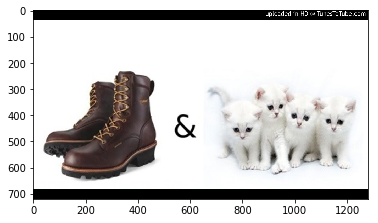

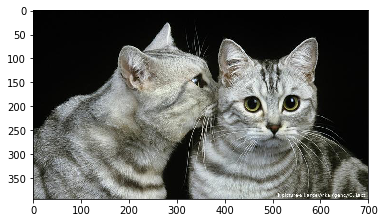

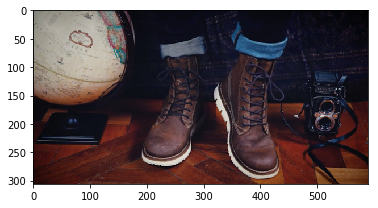

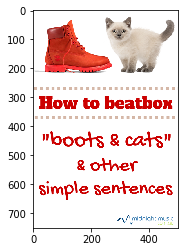

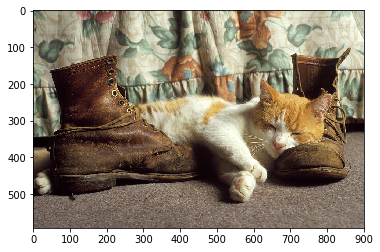

In [63]:
!mkdir -p $test_image_folder
!wget -O $test_image_folder/tabby.jpg https://images.fineartamerica.com/images-medium-large-5/1990s-ginger-and-white-tabby-cat-animal-images.jpg
!wget -O $test_image_folder/beatbox.jpg https://midnightmusic.com.au/wp-content/uploads/2014/08/How-to-beatbox-5001.png
!wget -O $test_image_folder/ampersand.jpg https://i.ytimg.com/vi/DsC5hNYpP9Y/maxresdefault.jpg
!wget -O $test_image_folder/boots.jpg https://d28m5bx785ox17.cloudfront.net/v1/img/w4r1gr5IKcC9tTcJG_vsJVbyjZ_SVKuFf3YBxtrGdFs=/d/l
!wget -O $test_image_folder/cats.jpg https://www.dw.com/image/42582511_401.jpg

for test_image in os.listdir(test_image_folder):
    display(HTML(f"<h4>{test_image}</h4>"))
    util.visualize_detection(f"{test_image_folder}/{test_image}", [], [])

## Step 2: Map our class names to OpenImages class IDs

OpenImages defines a hierarchy of object types (e.g. "swan" is a subtype of "bird"), and references each with a class ID instead of the human-readable name.

Since we want to find images containing boots and cats, our first job is to figure what OpenImages class IDs they correspond to.

We start by downloading the OpenImages metadata, below.

(Note we're only referencing the `test` subset of OpenImages as an easy way to keep data volumes small)

In [5]:
# Download and process the Open Images annotations.
os.makedirs(data_raw_prefix, exist_ok=True)
!wget -O $data_raw_prefix/annotations-bbox.csv https://storage.googleapis.com/openimages/2018_04/test/test-annotations-bbox.csv 
!wget -O $data_raw_prefix/class-descriptions.csv https://storage.googleapis.com/openimages/2018_04/class-descriptions.csv 
!wget -O $data_raw_prefix/labels-hierarchy.json https://storage.googleapis.com/openimages/2018_04/bbox_labels_600_hierarchy.json

--2019-12-08 07:46:51--  https://storage.googleapis.com/openimages/2018_04/test/test-annotations-bbox.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 2404:6800:4003:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52174204 (50M) [text/csv]
Saving to: ‘data/raw/annotations-bbox.csv’

data/raw/annotation 100%[===================>]  49.76M  22.7MB/s    in 2.2s    

2019-12-08 07:46:54 (22.7 MB/s) - ‘data/raw/annotations-bbox.csv’ saved [52174204/52174204]

--2019-12-08 07:46:54--  https://storage.googleapis.com/openimages/2018_04/class-descriptions.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 2404:6800:4003:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 475854 (465K) [text/csv]
Saving to: ‘data/raw/class-de

Now a case-insensitive lookup for our class names in the classes CSV:

In [56]:
# The class list is really long, so let's stream it instead of loading dataframe:
class_root_ids = { s: None for s in CLASS_NAMES }
classes_lower_notfound = { s.lower(): s for s in CLASS_NAMES }
with open(f"{data_raw_prefix}/class-descriptions.csv", "r") as f:
    for row in csv.reader(f):
        row_class_lower = row[1].lower()
        match = classes_lower_notfound.get(row_class_lower)
        if (match is not None):
            class_root_ids[match] = row[0]
            del classes_lower_notfound[row_class_lower]
            if (len(classes_lower_notfound) == 0):
                print("Class name -> root ID mapping done")
                break

print(class_root_ids)
if len(classes_lower_notfound):
    raise ValueError(
        f"IDs not found for these class names: {[v for (k,v) in classes_lower_notfound.items()]}"
    )

Class name -> root ID mapping done
{'Boot': '/m/01b638', 'Cat': '/m/01yrx'}


Next, we recurse down the ontology from these root classes to capture any child classes.

(Note that actually "boot" and "cat" are leaf nodes in OpenImages v4, but other common requests like "bird" are not).

In [55]:
with open(f"{data_raw_prefix}/labels-hierarchy.json", "r") as f:
    hierarchy = json.load(f)

def get_all_subclasses(class_id, tree):
    """Get the set of `class_id` and all matching subclasses from hierarchy `tree`"""
    def all_subtree_class_ids(subtree):
        if ("Subcategory" in subtree):
            return set([subtree["LabelName"]]).union(
                *[all_subtree_class_ids(s) for s in subtree["Subcategory"]]
            )
        else:
            return set([subtree["LabelName"]])
    if (tree["LabelName"] == class_id):
        return all_subtree_class_ids(tree)
    elif "Subcategory" in tree:
        return set().union(*[get_all_subclasses(class_id, s) for s in tree["Subcategory"]])
    else:
        return set()

class_id_sets = {
    name: get_all_subclasses(class_root_ids[name], hierarchy) for name in class_root_ids
}
print("Final OpenImages class ID sets:")
print(class_id_sets)

Final OpenImages class ID sets:
{'Boot': {'/m/01b638'}, 'Cat': {'/m/01yrx'}}


## Step 3: Find suitable example images

Now we've looked up the full range of applicable label IDs, we can use the OpenImages annotations to extract which image IDs will be interesting for us to train on (i.e. they contain boots and cats).

We deliberately search through the data-set in deterministic order, and only want to collect `N_EXAMPLES_PER_CLASS` images for each label but need to offset the ones we pick up by `BATCH_OFFSET` if this is non-zero.

In [6]:
# Skip these images with known bad quality content:
SKIP_IMAGES = {"251d4c429f6f9c39", "065ad49f98157c8d"}

# Dict[class_name][img_id] -> [class_name, xmin, xmax, ymin, ymax]
class_bbs = { name: defaultdict(list) for name in class_id_sets }

# BATCH_OFFSET allows 
n_images_needed = N_EXAMPLES_PER_CLASS * (BATCH_OFFSET + 1)

unfilled_class_names = set(CLASS_NAMES)
with open(f"{data_raw_prefix}/annotations-bbox.csv", "r") as f:
    for row in csv.reader(f):
        img_id, _, cls_id, conf, xmin, xmax, ymin, ymax, *_ = row
        if (img_id in SKIP_IMAGES):
            continue
        curr_unfilled_class_names = unfilled_class_names.copy()
        for name in curr_unfilled_class_names:
            if (cls_id in class_id_sets[name]):
                class_bbs[name][img_id].append([name, xmin, xmax, ymin, ymax])
                if (len(class_bbs[name]) >= n_images_needed):
                    unfilled_class_names.remove(name)
                    
if (len(unfilled_class_names)):
    print(
        "WARNING: Found fewer than ("
        + f"{N_EXAMPLES_PER_CLASS}x{BATCH_OFFSET+1}={n_images_needed}"
        + ") requested images for the following classes:\n"
        + "\n".join([f"{name} ({len(class_bbs[name])} images)" for name in unfilled_class_names])
    )

bbs = defaultdict(list)
for class_name in class_bbs:
    # Take last N_EXAMPLES_PER_CLASS images from each class (for BATCH_OFFSET)
    class_bbs_all_unfiltered = list(class_bbs[class_name].items())
    class_bbs_batch = class_bbs_all_unfiltered[-N_EXAMPLES_PER_CLASS:]
    class_bbs[class_name] = defaultdict(list, class_bbs_batch)
    # Concatenate each class together into the overall `bbs` set
    for (img_id, boxes) in class_bbs_batch:
        bbs[img_id] = bbs[img_id] + boxes

image_ids = bbs.keys()
n_images = len(image_ids)
print(f"Selected {n_images} images")

Selected 60 images


## Step 4: Upload images and manifest file to S3

We need our training image data in an accessible S3 bucket, and a [manifest](https://docs.aws.amazon.com/sagemaker/latest/dg/sms-data-input.html) file defining for SageMaker Ground Truth (and later our model) what images are in the data set and where to find them.

In the following cell, we:

* Copy each identified image directly from the OpenImages repository to our bucket
* Build up a local manifest file listing all the images
* Upload the manifest file to the bucket

This process should only take a few seconds with small data sets like we're dealing with here.

In [10]:
os.makedirs(f"{data_batch_prefix}/manifests", exist_ok=True)
manifest_loc = f"{data_batch_prefix}/manifests/input.manifest"

with open(manifest_loc, "w") as f:
    print("Copying images", end="")
    # TODO: Delete existing folder contents?
    for image_id in image_ids:
        print(".", end="")
        dest_key = f"{data_batch_prefix}/images/{image_id}.jpg"
        bucket.copy(
            {
                "Bucket": "open-images-dataset",
                "Key": f"test/{image_id}.jpg"
            },
            dest_key
        )
        f.write(json.dumps({ "source-ref": f"s3://{BUCKET_NAME}/{dest_key}" }) + "\n")
    print("")
    print(f"Images copied to s3://{BUCKET_NAME}/{data_batch_prefix}/images/")

bucket.upload_file(manifest_loc, manifest_loc)
print(f"Manifest uploaded to s3://{BUCKET_NAME}/{manifest_loc}")

Copying images............................................................
Images copied to s3://gt-object-detect-thewsey-ap-southeast-1/data/my-annotations/images/
Manifest uploaded to s3://gt-object-detect-thewsey-ap-southeast-1/data/my-annotations/input.manifest


## Step 5: Set up the SageMaker Ground Truth labelling job

Now that our images and a manifest file listing them are ready in S3, we'll set up the Ground Truth labelling job **in the [AWS console](https://console.aws.amazon.com)**.

Under *Services* go to *Amazon SageMaker*, and select *Ground Truth > Labeling Jobs* from the side-bar menu on the left.

**Note:** These steps assume you've either never used SageMaker Ground Truth before, or have already set up a Private Workforce that will be suitable for this task. If you have one or more private workforces configured already, but none of them are appropriate for this task, you'll need to go to *Ground Truth > Labeling workforces* **first** to create a new one.

### Job Details

Click the **Create labeling job** button, and you'll be asked to specify job details as follows:

* **Job name:** Choose a name to identify this labelling job, e.g. `boots-and-cats-batch-0`
* **Label name (The override checkbox):** Consider overriding this to `labels`
* **Input data location:** The path to the input manifest file in S3 (see output above)
* **Output data location:** Set this just to the parent folder of the input manifest
* **IAM role:** If you're not sure whether your existing roles have the sufficient permissions for Ground Truth, select the options to create a new role
* **Task type:** Image > Bounding box

<img src="BlogImages/JobDetailsIntro.png"/>

All other settings can be left as default. Record your choices for the label name and output data location below, because we'll need these later:

In [58]:
my_groundtruth_job_name = "bots-and-cats-batch-0" # TODO: "boots-and-cats-batch-0"?
my_groundtruth_output = f"s3://{BUCKET_NAME}/data/my-annotations"# TODO: Something like "s3://my-bucket-name/data/my-annotations"
my_groundtruth_labels = "labels"# TODO: "labels", or the same as your job name if you left the override checkbox unticked

### Workers

On the next screen, we'll configure **who** will annotate our data: Ground Truth allows you to define your own in-house *Private Workforces*; use *Vendor Managed Workforces* for specialist tasks; or use the public workforce provided by *Amazon Mechanical Turk*.

Select **Private** worker type, and you'll be prompted either to select from your existing private workforces, or create a new one if none exist.

To create a new private workforce if you need, simply follow the UI workflow with default settings. It doesn't matter what you call the workforce, and you can create a new Cognito User Group to define the workforce. **Add yourself** to the user pool by adding your email address: You should receive a confirmation email shortly with a temporary password and a link to access the annotation portal.

Automatic data labeling is applicable only for data sets over 1000 samples, so leave this turned **off** for now.

<img src="BlogImages/SelectPrivateWorkforce.png"/>

### Labeling Tool

Since you'll be labelling the data yourself, a brief description of the task should be fine in this case. When using real workforces, it's important to be really clear in this section about the task requirements and best practices - to ensure consistency of annotations between human workers.

For example: In the common case where we see a *pair* of boots from the side and one is almost entirely obscured, how should the image be annotated? Should *model* cats count, or only real ones?

The most important configuration here is to set the *options* to be the same as our `CLASS_NAMES` and in the same order: **Boot, Cat**

<img src="BlogImages/LabellingToolSetup.png"/>

Take some time to explore the other options for configuring the annotation tool; and when you're ready click "Create" to launch the labeling job.

## Step 6: Label those images!

Follow the link you received in your workforce invitation email to the workforce's **labelling portal**, and log in with the default password given in the email (which you'll be asked to change).

If you lose the portal link, you can always retrieve it through the *Ground Truth > Labeling Workforces* menu in the SageMaker console: Near the top of the summary of private workforces.

New jobs can sometimes take a minute or two to appear for workers, but you should soon see a screen like the below. Select the job and click "Start working" to enter the labelling tool.

**TODO: Screenshot**

Note that you can check on the progress of labelling jobs through the APIs as well as in the AWS console:

In [ ]:
smclient.describe_labeling_job(LabelingJobName=my_groundtruth_job_name)['LabelingJobStatus']

Label all the images in the tool by selecting the class and drawing boxes around the objects, and when done you will be brought back to the (now empty) jobs list screen above.

## Step 7: (Optional) Augment the labelled data

This repository contains an example output manifest (100 images) which we can use to augment our data set and improve our model's accuracy.

The script below **imports** the data to our bucket, since we don't have access to the S3 bucket where the annotation job was originally performed. We extract the OpenImages image ID/filename from each entry in the manifest; copy this image into our bucket; and create an updated output manifest with the new `source-ref`s.

The code includes some tips in case you want to re-purpose it for other data sources

In [35]:
# Utility function definition:
def import_manifest_file(manifest_file_path, updated_manifest_file_path, target_prefix):
    """Import a Ground Truth output.manifest file to the current S3 bucket
    Parameters:
    ----------
    manifest_file_path: str
        Local relative path to an output manifest which was created against a different S3 bucket
    updated_manifest_file_path: str
        Local relative path (and S3 key) to store the new manifest with updated S3 keys
    target_prefix: str
        Place in current S3 bucket to store the images and updated manifest
    """
    with open(manifest_file_path, "r") as f_source:
        with open(updated_manifest_file_path, "w") as f_target:
            print("Copying images", end="")
            for line in f_source:
                print(".", end="")
                datum = json.loads(line)
                image_file = datum["source-ref"].rpartition("/")[2]
                dest_key = f"{target_prefix}/images/{image_file}"
                bucket.copy(
                    {
                        "Bucket": "open-images-dataset",
                        "Key": f"test/{image_file}"
                    },
                    dest_key
                )
                datum["source-ref"] = f"s3://{BUCKET_NAME}/{dest_key}"
                f_target.write(json.dumps(datum) + "\n")
    print("")
    # Upload the updated manifest to S3 for our use in model fitting:
    bucket.upload_file(updated_manifest_file_path, updated_manifest_file_path)
    print(f"Augmentation manifest uploaded to:\ns3://{BUCKET_NAME}/{updated_manifest_file_path}")


# Import the augmentation data included in the repository:
augment_manifest_loc = f"{data_augment_prefix}/manifests/output/output.updated.manifest"
import_manifest_file(
    f"{data_augment_prefix}/manifests/output/output.manifest",
    augment_manifest_loc,
    data_augment_prefix
)

Copying images....................................................................................................
Augmentation manifest uploaded to s3://gt-object-detect-thewsey-ap-southeast-1/data/augmentation/manifests/output/output.updated.manifest


In [ ]:
# If wanting to import another manifest file:

# Ensure the folder creation, if you need to:
#os.makedirs("data/[SUBFOLDERNAME]/manifests/output", exist_ok=True)

# Download the output.manifest to our standard location:
#!aws s3 cp s3://WHEREVER-THE-OUTPUT.MANIFEST-LIVES ./data/[SUBFOLDERNAME]/manifests/output/output.manfiest
# (Or copy it some other way if you don't have access via S3)

# Import the file:
# import_manifest_file(
#     "data/[SUBFOLDERNAME]/manifests/output/output.manifest",
#     "data/[SUBFOLDERNAME]/manifests/output/output.updated.manifest",
#     "data/[SUBFOLDERNAME]",
# )

## Step 8: Consolidate the labeling results
Now that our own labelling job is complete and we've imported other data to augment our data-set, we'll consolidate the batches together into a single combined manifest file.

First, validate and adjust the below configuration for your data:

In [59]:
annotation_jobs = {
    # The batch you just annotated:
    BATCH_NAME: {
        # The label name you selected in the console:
        # (GroundTruth will set this equal to the job name by default)
        "label_name": my_groundtruth_labels, # TODO
        # This may be different if you selected something else for the output path other than:
        # s3://{BUCKET}/{batch_data_prefix}
        "manifest": f"{my_groundtruth_output}/manifests/output/output.manifest"
    },
    # The augmentation batch provided in the repo:
    # (Comment out this entry if you skipped importing this)
    "augmentation": {
        "label_name": "labels",
        "manifest": f"s3://{BUCKET_NAME}/data/augmentation/manifests/output/output.updated.manifest"
    }
    # Did you import any other batches?
}

print(json.dumps(annotation_jobs, indent=2))

{
  "my-annotations": {
    "label_name": "labels",
    "manifest": "s3://gt-object-detect-thewsey-ap-southeast-1/data/my-annotations/manifests/output/output.manifest"
  },
  "augmentation": {
    "label_name": "labels",
    "manifest": "s3://gt-object-detect-thewsey-ap-southeast-1/data/augmentation/manifests/output/output.updated.manifest"
  }
}


Read the contents from each manifest and consolidate in memory:

In [50]:
annotation_job_ids = list(annotation_jobs.keys())

for job_id in annotation_jobs:
    manifest_bucket, _, manifest_path = annotation_jobs[job_id]["manifest"][len("s3://"):].partition("/")
    manifest_folder, _, manifest_file = manifest_path.rpartition("/")
    os.makedirs(manifest_folder, exist_ok=True)
    s3.Bucket(manifest_bucket).download_file(manifest_path, manifest_path)
    with open(manifest_path, "r") as f:
        data = [json.loads(line) for line in f.readlines()]
        # Standardize label names:
        for datum in data:
            datum["labels"] = datum.pop(annotation_jobs[job_id]["label_name"])
        annotation_jobs[job_id]["data"] = data
        print(f"{len(data)} samples from annotation set {job_id}")

combined_manifest_data = [datum for job_id in annotation_jobs for datum in annotation_jobs[job_id]["data"]]
print(f"Got {len(combined_manifest_data)} total samples from {len(annotation_job_ids)} sets")

# The standardization above means these are always the attributes training will care about:
attribute_names = ["source-ref", "labels"]

# For illustration, this is what an entry in our combined manifest looks like:
combined_manifest_data[0]

100 samples from annotation set augmentation
Got 100 total samples from 1 sets


{'source-ref': 's3://gt-object-detect-thewsey-ap-southeast-1/data/augmentation/images/aedf80fdd1d76649.jpg',
 'labels-metadata': {'job-name': 'labeling-job/boots-and-cats-augmentation',
  'class-map': {'1': 'Cat', '0': 'Boot'},
  'human-annotated': 'yes',
  'objects': [{'confidence': 0.09}],
  'creation-date': '2019-12-06T18:43:36.393602',
  'type': 'groundtruth/object-detection'},
 'labels': {'annotations': [{'class_id': 0,
    'width': 570,
    'top': 0,
    'height': 583,
    'left': 33}],
  'image_size': [{'width': 663, 'depth': 3, 'height': 1024}]}}

## Step 9: Split training vs validation and upload final manifests

Now we have all our consolidated label sets (and all the referenced images uploaded in our S3 bucket), the final step is to split training vs validation data and upload a manifest for each:

In [46]:
# Shuffle output in place.
np.random.shuffle(combined_manifest_data)
    
n_samples_total = len(combined_manifest_data)
train_test_split_index = round(n_samples_total*0.8)

train_data = combined_manifest_data[:train_test_split_index]
validation_data = combined_manifest_data[train_test_split_index:]

n_samples_training = len(train_data)
n_samples_validation = len(validation_data)

with open(f"{DATA_PREFIX}/train.manifest", "w") as f:
    for line in train_data:
        f.write(json.dumps(line))
        f.write("\n")
    
with open(f"{DATA_PREFIX}/validation.manifest", "w") as f:
    for line in validation_data:
        f.write(json.dumps(line))
        f.write("\n")
        
bucket.upload_file(f"{DATA_PREFIX}/train.manifest", f"{DATA_PREFIX}/train.manifest")
bucket.upload_file(f"{DATA_PREFIX}/validation.manifest",f"{DATA_PREFIX}/validation.manifest")

In [ ]:
%store attribute_names

# Train an object detection model using Ground Truth labels
At this stage, we have fully labeled our dataset and we can train a machine learning model to perform object detection. We'll do so using the **augmented manifest** output of our labeling job - no additional file translation or manipulation required! For a more complete description of the augmented manifest, see our other [example notebook](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/ground_truth_labeling_jobs/object_detection_augmented_manifest_training/object_detection_augmented_manifest_training.ipynb).

In order to train the object detection model you will need to have resources limits set to allow the use of ml.p3.2xlarge instances, the default limit is 0. Make sure the limit request has been completed


**NOTE:** Object detection is a complex task, and training neural networks to high accuracy requires large datasets and careful hyperparameter tuning. The following cells illustrate how to train a neural network using a Ground Truth output augmented manifest, and how to interpret the results. However, we shouldn't expect a network trained on 10 or 1000 images to do a great job on unseen images!

First, we'll split our augmented manifest into a training set and a validation set using an 80/20 split and save the results to files that the model will use during training.

## Setup Input/Output Channels (Training and Validation)

Here we define S3 file paths for input and output data, the training image containing the object detection algorithm, and instantiate a SageMaker session.

In [52]:
train_channel = sagemaker.session.s3_input(
    f"s3://{BUCKET_NAME}/{DATA_PREFIX}/train.manifest",
    distribution="FullyReplicated",
    content_type="application/x-recordio",
    s3_data_type="AugmentedManifestFile",
    record_wrapping="RecordIO",
    attribute_names=attribute_names
)
                                        
validation_channel = sagemaker.session.s3_input(
    f"s3://{BUCKET_NAME}/{DATA_PREFIX}/validation.manifest",
    distribution="FullyReplicated",
    content_type="application/x-recordio",
    record_wrapping="RecordIO",
    s3_data_type="AugmentedManifestFile",
    attribute_names=attribute_names
)

## Configure the training job - Input data and Hyperparameters

Point to object detecition image uri

In [53]:
training_image = sagemaker.amazon.amazon_estimator.get_image_uri(
    region,
    "object-detection",
    repo_version="latest"
)
print (training_image)

475088953585.dkr.ecr.ap-southeast-1.amazonaws.com/object-detection:latest


Define Sagemaker estimator object with desired configuration.

In [226]:
estimator = sagemaker.estimator.Estimator(
    training_image,
    role,
    train_instance_count=1,
    train_instance_type="ml.p3.2xlarge",
    train_volume_size=50,
    input_mode="Pipe",
    train_max_run = 5*60*60,
    train_use_spot_instances=True,
    train_max_wait= 5*60*60,
    #checkpoint_s3_uri=f"s3://{BUCKET_NAME}/{CHECKPOINTS_PREFIX}",
    base_job_name="object-detection-demo",
    output_path=f"s3://{BUCKET_NAME}/{MODELS_PREFIX}",
)

Define model hyperparameters

In [227]:
estimator.set_hyperparameters(
    base_network="resnet-50",
    early_stopping=True,
    early_stopping_min_epochs=100,
    early_stopping_patience=20,
    epochs=400,
    image_shape=300,
    label_width=350,
    learning_rate=0.0002,
    lr_scheduler_factor=0.5,
    mini_batch_size=5,
    momentum=0.9,
    nms_threshold=0.45,
    num_classes=len(CLASS_NAMES),
    num_training_samples=str(n_samples_training),
    optimizer="sgd",
    overlap_threshold=0.5,
    use_pretrained_model=1,
    weight_decay=0.005,
)

Define input channels and configuration

Run training algorithm

In [197]:
%%time
estimator.fit({ "train": train_channel, "validation": validation_channel }, logs=True)

2019-12-07 07:22:13 Starting - Starting the training job...
2019-12-07 07:22:15 Starting - Launching requested ML instances......
2019-12-07 07:23:43 Starting - Preparing the instances for training.........
2019-12-07 07:25:14 Downloading - Downloading input data
2019-12-07 07:25:14 Training - Downloading the training image...
2019-12-07 07:25:28 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
[12/07/2019 07:25:30 INFO 140161182607168] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'label_width': u'350', u'early_stopping_min_epochs': u'10', u'epochs': u'30', u'overlap_threshold': u'0.5', u'lr_scheduler_factor': u'0.1', u'_num_kv_servers': u'auto', u'weight_decay': u'0.0005', u'mini_batch_size': u'32', u'use_pretrained_model': u'0', u'freeze_layer_pattern': u'', u'lr_scheduler_step': u'', u'early_stopping': u'False', u'early_stopping_patience': u'5', u'momentum

## Perform Hyperparameter Tuning

In [77]:
WITH_HPO=True

In [231]:
%%time
if (not WITH_HPO):
    estimator.fit({ "train": train_channel, "validation": validation_channel }, logs=True)
else:
    hyperparameter_ranges = {
        "learning_rate": sagemaker.tuner.ContinuousParameter(0.0001, 0.1),
        "momentum": sagemaker.tuner.ContinuousParameter(0.0, 0.99),
        "weight_decay": sagemaker.tuner.ContinuousParameter(0.0, 0.99),
        "mini_batch_size": sagemaker.tuner.IntegerParameter(1, n_samples_validation),
        "optimizer": sagemaker.tuner.CategoricalParameter(['sgd', 'adam', 'rmsprop', 'adadelta'])
    }

    tuner = sagemaker.tuner.HyperparameterTuner(
        estimator,
        "validation:mAP",
        hyperparameter_ranges,
        objective_type='Maximize',
        base_tuning_job_name="object-detection-tuning",
        max_jobs=60,
        max_parallel_jobs=3
    )
    
    tuner.fit(
        { "train": train_channel, "validation": validation_channel },
        include_cls_metadata=False
    )

# Deploy the Model 

Now that we've fully labeled our dataset and have a trained model, we want to use the model to perform inference.

Object detection only supports encoded .jpg and .png image formats as inference input for now. The output is in JSON format, or in JSON Lines format for batch transform.

## Realtime Inference

We now host the model with an endpoint and perform realtime inference.

This section involves several steps:
1. Create the model - Download the model artifacts from S3 into the container.
1. Create endpoint configuration - Create a configuration defining an endpoint.
2. Create endpoint - Use the configuration to create an inference endpoint.
3. Perform inference - Perform inference on some input data using the endpoint.
4. Clean up - Delete the endpoint and model


In [198]:
%%time
if (WITH_HPO):
    if (predictor_hpo):
        predictor_hpo.delete_endpoint()
    predictor_hpo = tuner.deploy(
        initial_instance_count=1,
        instance_type="ml.m4.xlarge"
    )
    predictor = predictor_hpo
else:
    if (predictor_std):
        predictor_std.delete_endpoint()
    predictor_std = estimator.deploy(
        initial_instance_count=1,
        instance_type="ml.m4.xlarge"
    )
    predictor = predictor_std

--------------------------------------------------------------------------------------------------!CPU times: user 550 ms, sys: 24.8 ms, total: 575 ms
Wall time: 8min 14s


## Step XX: Evaluate on unseen images

We'll fetch a few selected images from around the web to see how our detector performs:

In [211]:
test_image_folder = DATA_PREFIX + "test"
!mkdir -p $test_image_folder
!wget -O $test_image_folder/tabby.jpg https://images.fineartamerica.com/images-medium-large-5/1990s-ginger-and-white-tabby-cat-animal-images.jpg
!wget -O $test_image_folder/beatbox.jpg https://midnightmusic.com.au/wp-content/uploads/2014/08/How-to-beatbox-5001.png
!wget -O $test_image_folder/ampersand.jpg https://i.ytimg.com/vi/DsC5hNYpP9Y/maxresdefault.jpg
!wget -O $test_image_folder/boots.jpg https://d28m5bx785ox17.cloudfront.net/v1/img/w4r1gr5IKcC9tTcJG_vsJVbyjZ_SVKuFf3YBxtrGdFs=/d/l
!wget -O $test_image_folder/cats.jpg https://www.dw.com/image/42582511_401.jpg

--2019-12-07 08:09:14--  https://d28m5bx785ox17.cloudfront.net/v1/img/w4r1gr5IKcC9tTcJG_vsJVbyjZ_SVKuFf3YBxtrGdFs=/d/l
Resolving d28m5bx785ox17.cloudfront.net (d28m5bx785ox17.cloudfront.net)... 52.84.225.208, 52.84.225.4, 52.84.225.43, ...
Connecting to d28m5bx785ox17.cloudfront.net (d28m5bx785ox17.cloudfront.net)|52.84.225.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 405842 (396K) [image/png]
Saving to: ‘data/test/boots.jpg’

data/test/boots.jpg 100%[===================>] 396.33K   412KB/s    in 1.0s    

2019-12-07 08:09:16 (412 KB/s) - ‘data/test/boots.jpg’ saved [405842/405842]



Now send each of our test images to the predictor endpoint, and visualize the results.

(The `visualize_detection()` function is provided in the `util` folder, and just uses matplotlib to plot the provided detection boxes over the image)

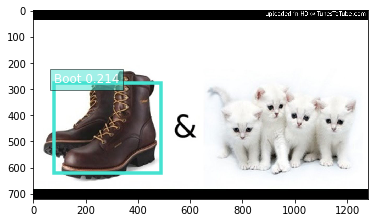

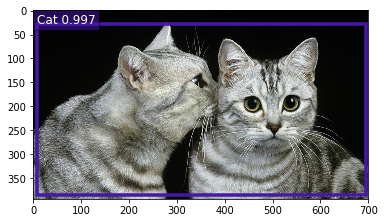

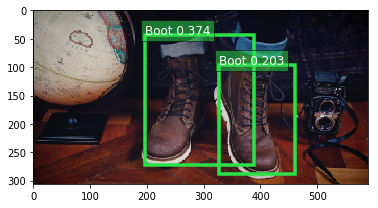

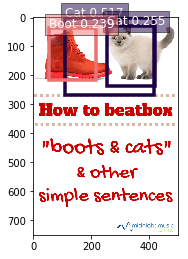

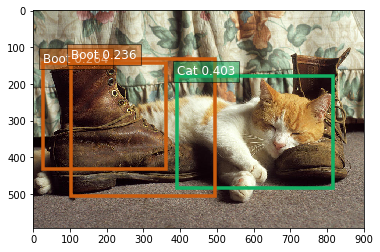

In [235]:
for test_image in os.listdir(test_image_folder):
    test_image_path = f"{test_image_folder}/{test_image}"
    with open(test_image_path, "rb") as f:
        payload = bytearray(f.read())

    client = boto3.client("sagemaker-runtime")
    response = client.invoke_endpoint(
        EndpointName=predictor.endpoint,
        ContentType='application/x-image',
        Body=payload
    )

    result = response['Body'].read()
    result = json.loads(result)
    # result["prediction"] is a list of [class_ix, confidence, y1, y2, x1, x2] detections.
    display(HTML(f"<h4>{test_image}</h4>"))
    util.visualize_detection(
        test_image_path,
        result["prediction"],
        CLASS_NAMES,
        thresh=0.2
    )

## Clean up

Finally, let's clean up and delete this endpoint.

In [ ]:
if (predictor_hpo):
    print("Deleting HPO-optimized predictor endpoint")
    predictor_hpo.delete_endpoint()
if (predictor_std):
    print("Deleting standard (non-HPO) predictor endpoint")
    predictor_std.delete_endpoint()

## Review

We covered a lot of ground in this notebook! Let's recap what we accomplished. First we started with an unlabeled dataset (technically, the dataset was previously labeled by the authors of the dataset, but we discarded the original labels for the purposes of this demonstration). Next, we created a SageMake Ground Truth labeling job and generated new labels for all of the images in our dataset. Then we split this file into a training set and a validation set and trained a SageMaker object detection model. Next, we trained a new model using these Ground Truth results and submitted a batch job to label a held-out image from the original dataset. Finally, we created a hosted model endpoint and used it to make a live prediction for the same held-out image.